In [1]:
from google.colab import files
import zipfile
import os

# Upload the dataset zip file
uploaded = files.upload()

# Unzip the file (replace with your actual filename)
zip_filename = "Dataset of X-rays.zip"
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall('TB_Dataset')

# Verify the folder structure
!ls TB_Dataset

Saving Dataset of X-rays.zip to Dataset of X-rays.zip
'Normal Chest X-rays'  'TB Chest X-rays'


In [2]:
zip_filename = "Dataset of X-rays.zip"  # Replace with your actual filename if different

# Extract to a folder named "TB_Dataset"
extract_path = "/content/TB_Dataset"
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verify the extracted folders
!ls {extract_path}

'Normal Chest X-rays'  'TB Chest X-rays'


In [3]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns


Plotting sample images from Normal folder:


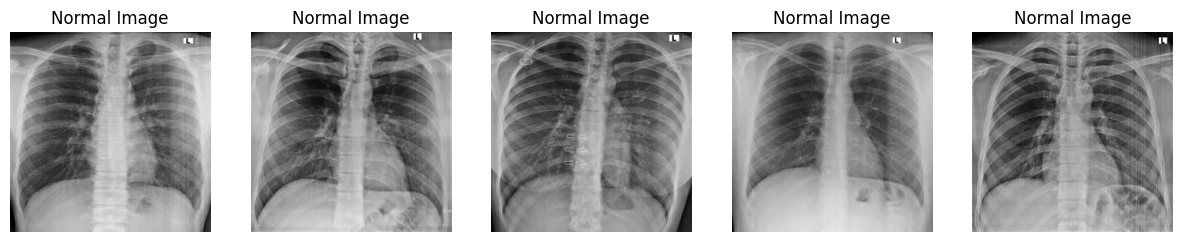


Plotting sample images from Tuberculosis folder:


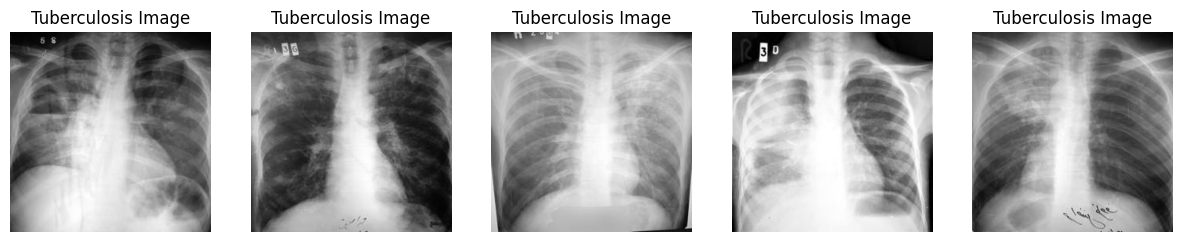

In [4]:
import matplotlib.pyplot as plt
import cv2

def plot_sample_images(folder_path, label, sample_size=5):
    files = os.listdir(folder_path)[:sample_size]
    plt.figure(figsize=(15, 5))
    for i, file in enumerate(files):
        img_path = os.path.join(folder_path, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        plt.subplot(1, sample_size, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{label} Image")
        plt.axis('off')
    plt.show()

print("\nPlotting sample images from Normal folder:")
plot_sample_images("/content/TB_Dataset/Normal Chest X-rays", "Normal")

print("\nPlotting sample images from Tuberculosis folder:")
plot_sample_images("/content/TB_Dataset/TB Chest X-rays", "Tuberculosis")


In [5]:
import os
import cv2
import numpy as np
from PIL import Image, ImageFile
import warnings

# Configure PIL to be more tolerant of image files
ImageFile.LOAD_TRUNCATED_IMAGES = True

def detect_corrupt_images(dataset_path, target_size=(224, 224)):
    """
    Detect and handle corrupt images in a dataset

    Args:
        dataset_path: Path to dataset directory with class subfolders
        target_size: Target image dimensions for validation

    Returns:
        Tuple: (valid_images, valid_labels, corrupt_files, report)
    """
    valid_images = []
    valid_labels = []
    corrupt_files = []
    report = {
        'total_files': 0,
        'loaded_successfully': 0,
        'corrupt_files': 0,
        'class_distribution': {}
    }

    class_folders = ['Normal Chest X-rays', 'TB Chest X-rays']  # Folder names match your dataset

    for class_idx, class_name in enumerate(class_folders):  # Fixed typo: class_folders (was class_folders)
        class_path = os.path.join(dataset_path, class_name)
        if not os.path.exists(class_path):  # Check if folder exists
            print(f"Warning: Directory not found - {class_path}")
            continue

        report['class_distribution'][class_name] = 0

        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            report['total_files'] += 1

            try:
                # Attempt to load with OpenCV first
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    img = cv2.imread(img_path)

                    if img is None:
                        # Fallback to PIL if OpenCV fails
                        try:
                            img = np.array(Image.open(img_path).convert('RGB'))
                        except Exception as pil_error:
                            raise ValueError(f"Both OpenCV and PIL failed: {str(pil_error)}")

                    # Convert color space if needed (OpenCV loads as BGR)
                    if len(img.shape) == 3 and img.shape[2] == 3:
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    elif len(img.shape) == 2:
                        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

                    # Validate image content
                    if img.size == 0:
                        raise ValueError("Empty image data")

                    # Resize to target dimensions
                    img = cv2.resize(img, target_size)
                    if img.shape != (*target_size, 3):
                        raise ValueError(f"Invalid shape after resize: {img.shape}")

                # If all checks passed
                valid_images.append(img)  # Now all images have same shape
                valid_labels.append(class_idx)
                report['loaded_successfully'] += 1
                report['class_distribution'][class_name] += 1

            except Exception as e:
                corrupt_files.append({
                    'path': img_path,
                    'error': str(e)
                })
                report['corrupt_files'] += 1
                continue

    # Convert to numpy arrays - now safe because all images have same shape
    if valid_images:  # Only convert if we have valid images
        valid_images = np.array(valid_images, dtype=np.uint8)
        valid_labels = np.array(valid_labels)
    else:
        valid_images = np.array([])
        valid_labels = np.array([])

    return valid_images, valid_labels, corrupt_files, report

# Usage Example
if __name__ == "__main__":
    dataset_path = "/content/TB_Dataset"

    try:
        valid_images, valid_labels, corrupt_files, report = detect_corrupt_images(dataset_path)

        print("\n=== Corruption Detection Report ===")
        print(f"Total files scanned: {report['total_files']}")
        print(f"Successfully loaded: {report['loaded_successfully']}")
        print(f"Corrupt files found: {report['corrupt_files']}")

        if report['loaded_successfully'] > 0:
            print("\nClass distribution of valid images:")
            for class_name, count in report['class_distribution'].items():
                print(f"- {class_name}: {count} ({(count/report['loaded_successfully'])*100:.1f}%)")

            # Print sample image info
            print(f"\nSample image shape: {valid_images[0].shape if len(valid_images) > 0 else 'N/A'}")
            print(f"Number of channels: {valid_images[0].shape[2] if len(valid_images) > 0 else 'N/A'}")

        if corrupt_files:
            print("\nFirst 5 corrupt files:")
            for corrupt in corrupt_files[:5]:
                print(f"Path: {corrupt['path']}")
                print(f"Error: {corrupt['error']}\n")

    except Exception as e:
        print(f"Error processing dataset: {str(e)}")


=== Corruption Detection Report ===
Total files scanned: 3008
Successfully loaded: 3008
Corrupt files found: 0

Class distribution of valid images:
- Normal Chest X-rays: 514 (17.1%)
- TB Chest X-rays: 2494 (82.9%)

Sample image shape: (224, 224, 3)
Number of channels: 3


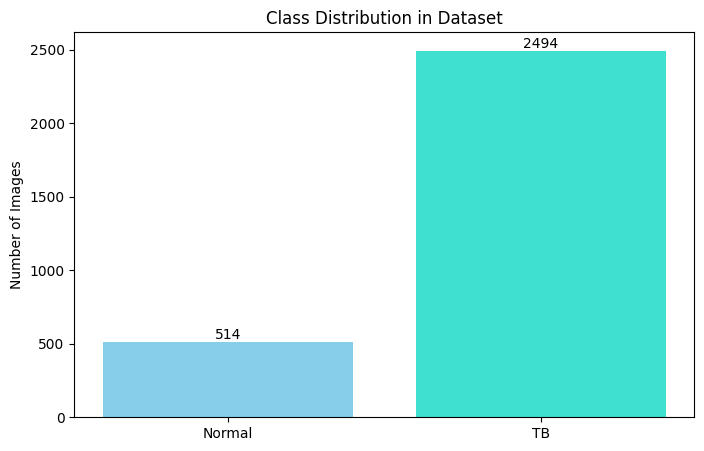

In [6]:
import os
import matplotlib.pyplot as plt
from collections import Counter

def load_labels(dataset_path):
    """Load image labels from dataset directory"""
    labels = []
    for class_idx, class_name in enumerate(['Normal Chest X-rays', 'TB Chest X-rays']):
        class_dir = os.path.join(dataset_path, class_name)
        labels.extend([class_idx] * len(os.listdir(class_dir)))
    return labels

def plot_class_distribution(dataset_path):
    """Visualize class balance"""
    labels = load_labels(dataset_path)
    counts = Counter(labels)

    plt.figure(figsize=(8, 5))
    bars = plt.bar(['Normal', 'TB'], [counts[0], counts[1]], color=['skyblue', 'turquoise'])

    # Add counts on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height,
                f'{height}', ha='center', va='bottom')

    plt.title('Class Distribution in Dataset')
    plt.ylabel('Number of Images')
    plt.show()

plot_class_distribution("/content/TB_Dataset")

In [7]:
def load_dataset(directory):
    images = []
    labels = []

    # TB class (label 1)
    tb_dir = os.path.join(directory, 'TB Chest X-rays')
    for img_file in os.listdir(tb_dir):
        img_path = os.path.join(tb_dir, img_file)
        try:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))
            images.append(img)
            labels.append(1)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

    # Normal class (label 0)
    normal_dir = os.path.join(directory, 'Normal Chest X-rays')
    for img_file in os.listdir(normal_dir):
        img_path = os.path.join(normal_dir, img_file)
        try:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))
            images.append(img)
            labels.append(0)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

    return np.array(images), np.array(labels)


In [8]:
dataset_path = "/content/TB_Dataset"
X, y = load_dataset(dataset_path)

In [9]:
# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [10]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=32, shuffle=True)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32, shuffle=False)


In [11]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.6 MB/s eta 0:00:00


In [12]:
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [13]:
from keras_tuner import HyperParameters
from tensorflow.keras import backend as K
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Custom F1-Score metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = K.round(y_pred)
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + K.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


hp = HyperParameters()

def build_model(base_model_name, input_shape=(224, 224, 3)):
    """Factory function to build different transfer learning models"""
    # Create base model
    if base_model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'EfficientNetB0':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError(f"Unknown model: {base_model_name}")

    # Freeze base layers
    for layer in base_model.layers:
        layer.trainable = False

    hp_units = hp.Int(f'units_{base_model_name}', min_value=512, max_value=2048, step=256)
    hp_dropout = hp.Float(f'dropout_{base_model_name}', min_value=0.1, max_value=0.3, step=0.1)
    hp_learning_rate = hp.Choice(f'learning_rate_{base_model_name}', values=[1e-2, 1e-3, 1e-4])

    # Add custom head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(units=hp_units, activation='relu')(x)
    x = Dropout(hp_dropout)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(
        optimizer=Adam(learning_rate=hp_learning_rate),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            F1Score(name='f1_score')
        ]
    )

    return model

# Prepare validation data for ROC callback
val_data = next(iter(val_generator))

# Train multiple models
models = {
    'ResNet50': build_model('ResNet50'),
    'VGG16': build_model('VGG16'),
    'EfficientNetB0': build_model('EfficientNetB0')
}

callbacks = [
    EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=3)
]

history = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    history[name] = model.fit(
        train_generator,
        epochs=30,
        validation_data=val_generator,
        callbacks = callbacks
    )
    model.save(f"{name}_tb_detector.h5")



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Training ResNet50...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 57s 605ms/step - accuracy: 0.7504 - f1_score: 0.8442 - loss: 1.4026 - precision: 0.8172 - recall: 0.8771 - val_accuracy: 0.8293 - val_f1_score: 0.9067 - val_loss: 0.4563 - val_precision: 0.8293 - val_recall: 1.0000 - learning_rate: 0.0100
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 404ms/step - accuracy: 0.8344 - f1_score: 0.9097 - loss: 0.4604 - precision: 0.8344 - recall: 1.0000 - val_accuracy: 0.8293 - val_f1_score: 0.9067 - val_loss: 0.4591 - val_precision: 0.8293 - val_recall: 1.0000 - learning_rate: 0.0100
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 411ms/step - accuracy: 0.8312 - f1_score: 0.9077 - loss: 0.4701 - precision: 0.8312 - recall: 1.0000 - val_accuracy: 0.8293 - val_f1_score: 0.9067 - val_loss: 0.4503 - val_precision: 0.8293 - val_recall: 1.0000 - learning_rate: 0.0100
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 413ms/step - accuracy: 0.8129 - f1_score: 0.8968 - loss: 0.4841 - precision: 0.8129 - recall: 1.0000 - val_accuracy: 0.8293 - v


Training VGG16...
Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 57s 644ms/step - accuracy: 0.8038 - f1_score: 0.8772 - loss: 0.6007 - precision: 0.8505 - recall: 0.9089 - val_accuracy: 0.8825 - val_f1_score: 0.9237 - val_loss: 0.2602 - val_precision: 1.0000 - val_recall: 0.8583 - learning_rate: 0.0100
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 449ms/step - accuracy: 0.9502 - f1_score: 0.9700 - loss: 0.1411 - precision: 0.9717 - recall: 0.9684 - val_accuracy: 0.9667 - val_f1_score: 0.9795 - val_loss: 0.0946 - val_precision: 1.0000 - val_recall: 0.9599 - learning_rate: 0.0100
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 444ms/step - accuracy: 0.9636 - f1_score: 0.9780 - loss: 0.1022 - precision: 0.9736 - recall: 0.9824 - val_accuracy: 0.9157 - val_f1_score: 0.9465 - val_loss: 0.2276 - val_precision: 1.0000 - val_recall: 0.8984 - learning_rate: 0.0100
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 42s 458ms/step - accuracy: 0.9622 - f1_score: 0.9772 - loss: 0.1005 - precision: 0.9774 - recall: 0.9771 - val_a


Training EfficientNetB0...
Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 71s 716ms/step - accuracy: 0.7667 - f1_score: 0.8650 - loss: 1.0112 - precision: 0.8267 - recall: 0.9084 - val_accuracy: 0.8293 - val_f1_score: 0.9067 - val_loss: 0.4663 - val_precision: 0.8293 - val_recall: 1.0000 - learning_rate: 0.0100
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 375ms/step - accuracy: 0.8197 - f1_score: 0.9008 - loss: 0.4778 - precision: 0.8197 - recall: 1.0000 - val_accuracy: 0.8293 - val_f1_score: 0.9067 - val_loss: 0.4588 - val_precision: 0.8293 - val_recall: 1.0000 - learning_rate: 0.0100
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 379ms/step - accuracy: 0.8327 - f1_score: 0.9086 - loss: 0.4571 - precision: 0.8327 - recall: 1.0000 - val_accuracy: 0.8293 - val_f1_score: 0.9067 - val_loss: 0.4712 - val_precision: 0.8293 - val_recall: 1.0000 - learning_rate: 0.0100
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 378ms/step - accuracy: 0.8426 - f1_score: 0.9145 - loss: 0.4501 - precision: 0.8426 - recall: 1.000


Evaluating ResNet50...
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 451ms/step


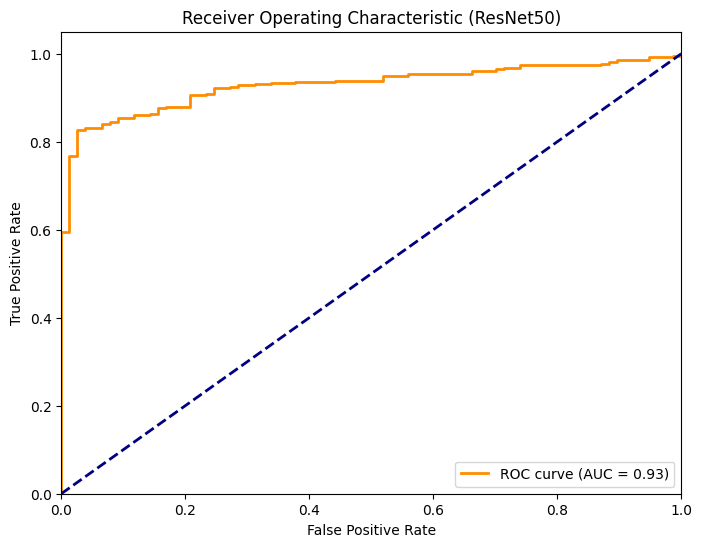

AUC-ROC: 0.9292

Evaluating VGG16...
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 341ms/step


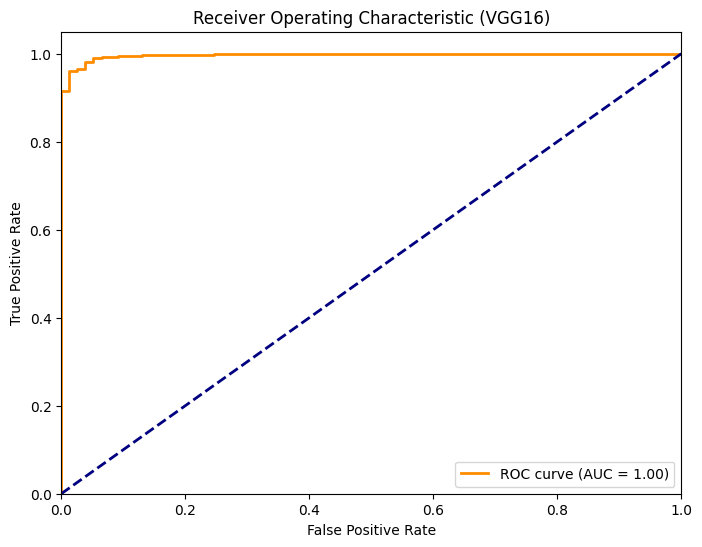

AUC-ROC: 0.9968

Evaluating EfficientNetB0...
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 512ms/step


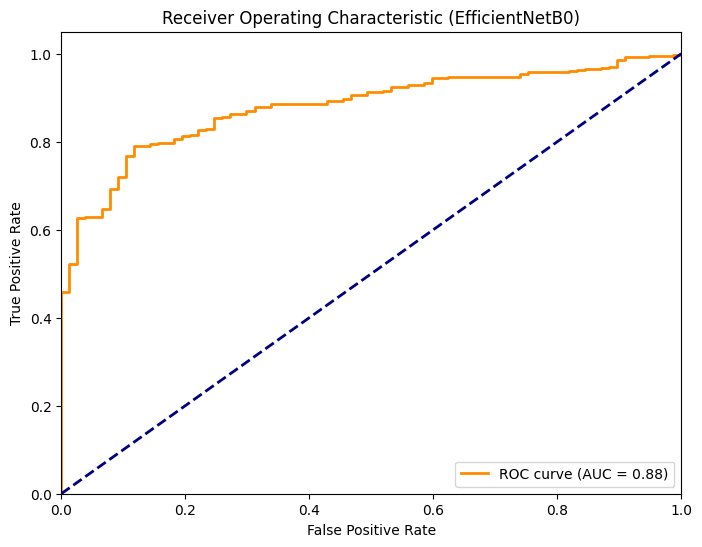

AUC-ROC: 0.8802

Model Comparison (AUC-ROC):
ResNet50: 0.9292
VGG16: 0.9968
EfficientNetB0: 0.8802


In [14]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def plot_roc_auc(model, test_generator, model_name):
    """Calculate and plot ROC curve with AUC score"""
    # Get true labels and predicted probabilities
    y_true = y_test
    y_pred_prob = model.predict(test_generator).ravel()

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic ({model_name})')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

# After model training, evaluate on test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow(X_test, y_test, batch_size=32, shuffle=False)

# Evaluate all models
results = {}
for name, model in models.items():
    print(f"\nEvaluating {name}...")
    roc_auc = plot_roc_auc(model, test_generator, name)
    results[name] = roc_auc
    print(f"AUC-ROC: {roc_auc:.4f}")

# Print comparative results
print("\nModel Comparison (AUC-ROC):")
for model_name, score in results.items():
    print(f"{model_name}: {score:.4f}")